**Objective**

Our ojective is to build a model to determine if a building will have an insurance claim during a specific period using building characteristics. In this notebook we shall explore and apply four machine learning algorithms: Support Vector Machine (SVM), Linear Regression, k-nearest Neighbors (KNN), and Naive Bayes. We aslo use  Area Under the Curve (AUC) as the evaluation metric.

**Importing the libraries**

In [227]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc
import warnings
warnings.filterwarnings("ignore")


In [228]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [229]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [230]:
#Reading the first 5 rows of the dataset
df = pd.read_csv('/content/drive/MyDrive/Datasets/Insurance/train_data.csv')
df.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [231]:
#Description of data in each column
variable_description = pd.DataFrame({
    'Variable': ['Customer Id','YearOfObservation', 'Insured_Period	','Residential', 'Building_Painted', 'Building_Fenced','Garden', 'Settlement','Building Dimension', 'Building_Type','Date_of_Occupancy','NumberOfWindows', 'Geo Code', 'Claim' ],
   'Description': ['Identification number for the Policy holder', 'year of observation for the insured policy', 'duration of insurance policy in Olusola Insurance. (Ex: Full year insurance, Policy Duration = 1; 6 months = 0.5', 'is the building a residential building or not', 'is the building painted or not (N-Painted, V-Not Painted)', 'is the building fence or not (N-Fenced, V-Not Fenced)', 'building has garden or not (V-has garden; O-no garden)', 'Area where the building is located. (R- rural area; U- urban area)', 'Size of the insured building in m2', 'The type of building (Type 1, 2, 3, 4)', 'date building was first occupied', 'number of windows in the building', 'Geographical Code of the Insured building', 'target variable. (0: no claim, 1: at least one claim over insured period)']})
variable_description

,Variable,Description
0,Customer Id,Identification number for the Policy holder
1,YearOfObservation,year of observation for the insured policy
2,Insured_Period\t,duration of insurance policy in Olusola Insura...
3,Residential,is the building a residential building or not
4,Building_Painted,"is the building painted or not (N-Painted, V-N..."
5,Building_Fenced,"is the building fence or not (N-Fenced, V-Not ..."
6,Garden,building has garden or not (V-has garden; O-no...
7,Settlement,Area where the building is located. (R- rural ...
8,Building Dimension,Size of the insured building in m2
9,Building_Type,"The type of building (Type 1, 2, 3, 4)"


In [232]:
#checking shape of dataframe
df.shape

(7160, 14)

We notice that the train dataset has 7160 rows and 14 columns

In [233]:
#checking for categorical features in each column
df.nunique()

Customer Id           7160
YearOfObservation        5
Insured_Period         401
Residential              2
Building_Painted         2
Building_Fenced          2
Garden                   2
Settlement               2
Building Dimension    2043
Building_Type            4
Date_of_Occupancy      134
NumberOfWindows         11
Geo_Code              1307
Claim                    2
dtype: int64

In [234]:
#Description for numerical data in the dataset
df.describe()

,YearOfObservation,Insured_Period,Residential,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,7160.000000,7160.000000,7160.000000,7054.000000,7160.000000,6652.000000,7160.000000
mean,2013.669553,0.909758,0.305447,1883.727530,2.186034,1964.456404,0.228212
std,1.383769,0.239756,0.460629,2278.157745,0.940632,36.002014,0.419709
min,2012.000000,0.000000,0.000000,1.000000,1.000000,1545.000000,0.000000
25%,2012.000000,0.997268,0.000000,528.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,2289.750000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,20940.000000,4.000000,2016.000000,1.000000


In [235]:
#Description of categorical data in dataset
df.describe(include='O').T

,count,unique,top,freq
Customer Id,7160,7160,H14663,1
Building_Painted,7160,2,V,5382
Building_Fenced,7160,2,N,3608
Garden,7153,2,O,3602
Settlement,7160,2,R,3610
NumberOfWindows,7160,11,.,3551
Geo_Code,7058,1307,6088,143


In [236]:
#Checking for the datatypes of each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


In [237]:
#Checking for null values
df.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [238]:
df.isnull().sum().sum()

723

We have a total of 723 missing values in the dataset

In [239]:
#Investigating the NumberOfWindows further
df.NumberOfWindows.value_counts()

   .    3551
4        939
3        844
5        639
2        363
6        306
7        211
8        116
1         75
>=10      67
9         49
Name: NumberOfWindows, dtype: int64

In [240]:
df['Geo_Code'].value_counts()

6088     143
33063    137
6083     113
13206     98
31555     87
        ... 
59650      1
59656      1
60057      1
60172      1
2B353      1
Name: Geo_Code, Length: 1307, dtype: int64

In [241]:
#Using mode to replace missing values in Geo_Code
df['Geo_Code'] = df['Geo_Code'].fillna(df['Geo_Code'].mode()[0])

In [242]:
#Using mode to replace missing values in Garden
df['Garden'] = df['Garden'].fillna(df['Garden'].mode()[0])

In [243]:
#Distribution of data is skewed hence we use median
df['Date_of_Occupancy'] = df['Date_of_Occupancy'].fillna(df['Date_of_Occupancy'].median())

In [244]:
#Distribution of data is skewed hence we use median
df['Building Dimension'] = df['Building Dimension'].fillna(df['Building Dimension'].median())

In [245]:
#The column NumberOfWindows contain a high number of special characters(.) which have no meaning and dont add value to the model hence we shall drop this column and the Customer Id is redunant data
df.drop(columns=['NumberOfWindows','Customer Id','Geo_Code'],inplace=True)

In [246]:
df.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Claim
0,2013,1.0,0,N,V,V,U,290.0,1,1960.0,0
1,2015,1.0,0,V,N,O,R,490.0,1,1850.0,0
2,2014,1.0,0,N,V,V,U,595.0,1,1960.0,0
3,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,0
4,2014,1.0,0,V,N,O,R,680.0,1,1800.0,0


In [247]:
#Checking to comfirm we've dealt with all null values
df.isnull().sum()

YearOfObservation     0
Insured_Period        0
Residential           0
Building_Painted      0
Building_Fenced       0
Garden                0
Settlement            0
Building Dimension    0
Building_Type         0
Date_of_Occupancy     0
Claim                 0
dtype: int64

In [248]:
#columns have now reduced from 14 to 12
df.shape

(7160, 11)

**Visualization**

Distribution of Categorical data

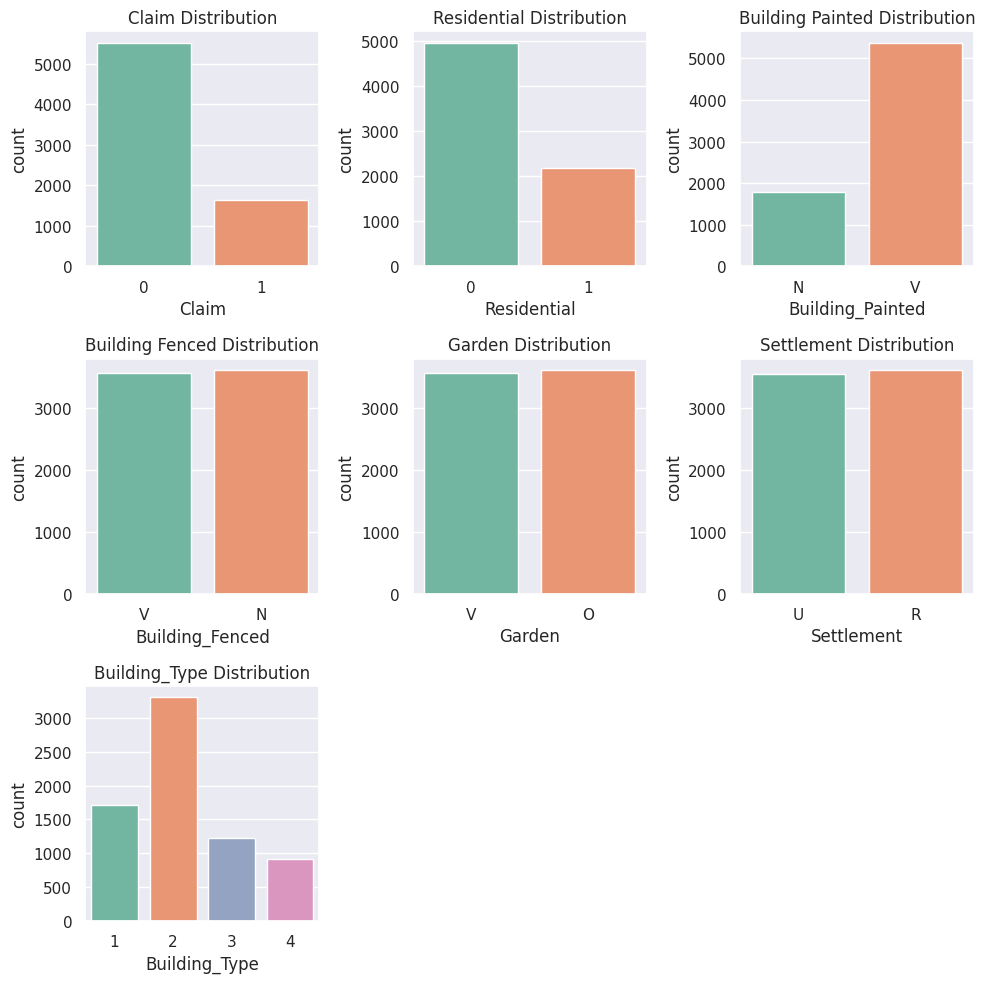

In [249]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
sns.set_theme(style="darkgrid")

# Plot the Claim distribution
sns.countplot(data=df, x='Claim', ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Claim Distribution')


# Plot the Residential distribution
sns.countplot(data=df, x='Residential', ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Residential Distribution')


# Plot the Building Painted distribution
sns.countplot(data=df, x='Building_Painted', ax=axes[0, 2], palette='Set2')
axes[0, 2].set_title('Building Painted Distribution')

# Plot the Building Fenced distribution
sns.countplot(data=df, x='Building_Fenced', ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Building Fenced Distribution')

#Plot the Garden distribution
sns.countplot(data=df, x='Garden', ax=axes[1, 1],palette='Set2')
axes[1, 1].set_title('Garden Distribution')

# Plot the Settlement distribution
sns.countplot(data=df, x='Settlement', ax=axes[1, 2],palette='Set2')
axes[1, 2].set_title('Settlement Distribution')

#Plot the Building_Type distribution
sns.countplot(data=df, x='Building_Type', ax=axes[2, 0],palette='Set2')
axes[2, 0].set_title('Building_Type Distribution')

fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


From here, we can notice that
1. The target variable Claim is imbalanced
2. Most buildings in the dataset are non residential
3. Most buildings are not painted
4. The amount of fenced and non fenced buildings is almost equal  
5. Similary, the amount of houses with gardens is almost equal to those without gardens
6. The settlement of houses in rural and urban areas is balanced
7. Most houses are of type 2 and few are of type 4

**Distribution of continuous variables**

In [250]:
#Creating a list for numerical columns
numerical_cont =['Building Dimension', 'Date_of_Occupancy']

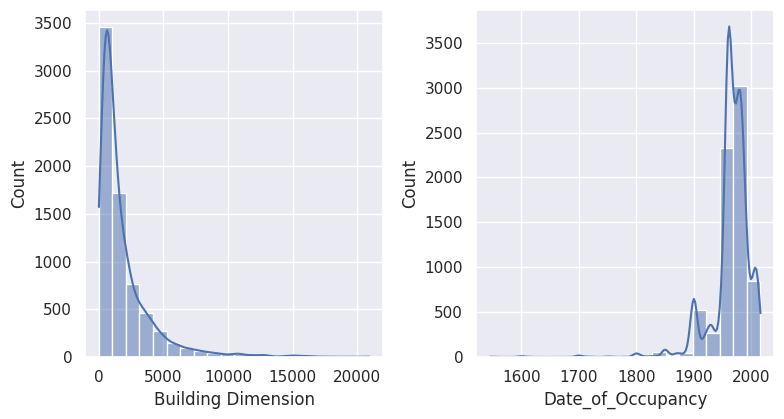

In [251]:
#Plotting a histplot for the numerical columns
plt.figure(figsize=(8, 8))
for i, column in enumerate(numerical_cont, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[column], bins=20, kde = True)
plt.tight_layout()
plt.show()


Frm here, we can notice that
1. The Building Dimension is right skewed, most houses have dimesnions ranging from 0 to 10000
2.The Date_of_Occupacy is left skewed, most houses where occuppied between 1900 to 2000

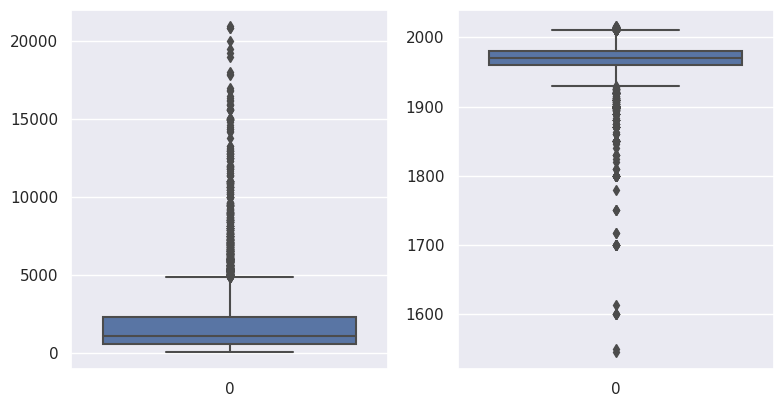

In [252]:
#Plotting boxplots to check for outliers
plt.figure(figsize=(8, 8))
for i, column in enumerate(numerical_cont, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(df[column])
plt.tight_layout()
plt.show()

As expected we can notice that we have outliers in both the Building Dimensions and Date_Of_Occupacy so we'll have to deal with them later on.

**Relationship between categorical variables and Claim**

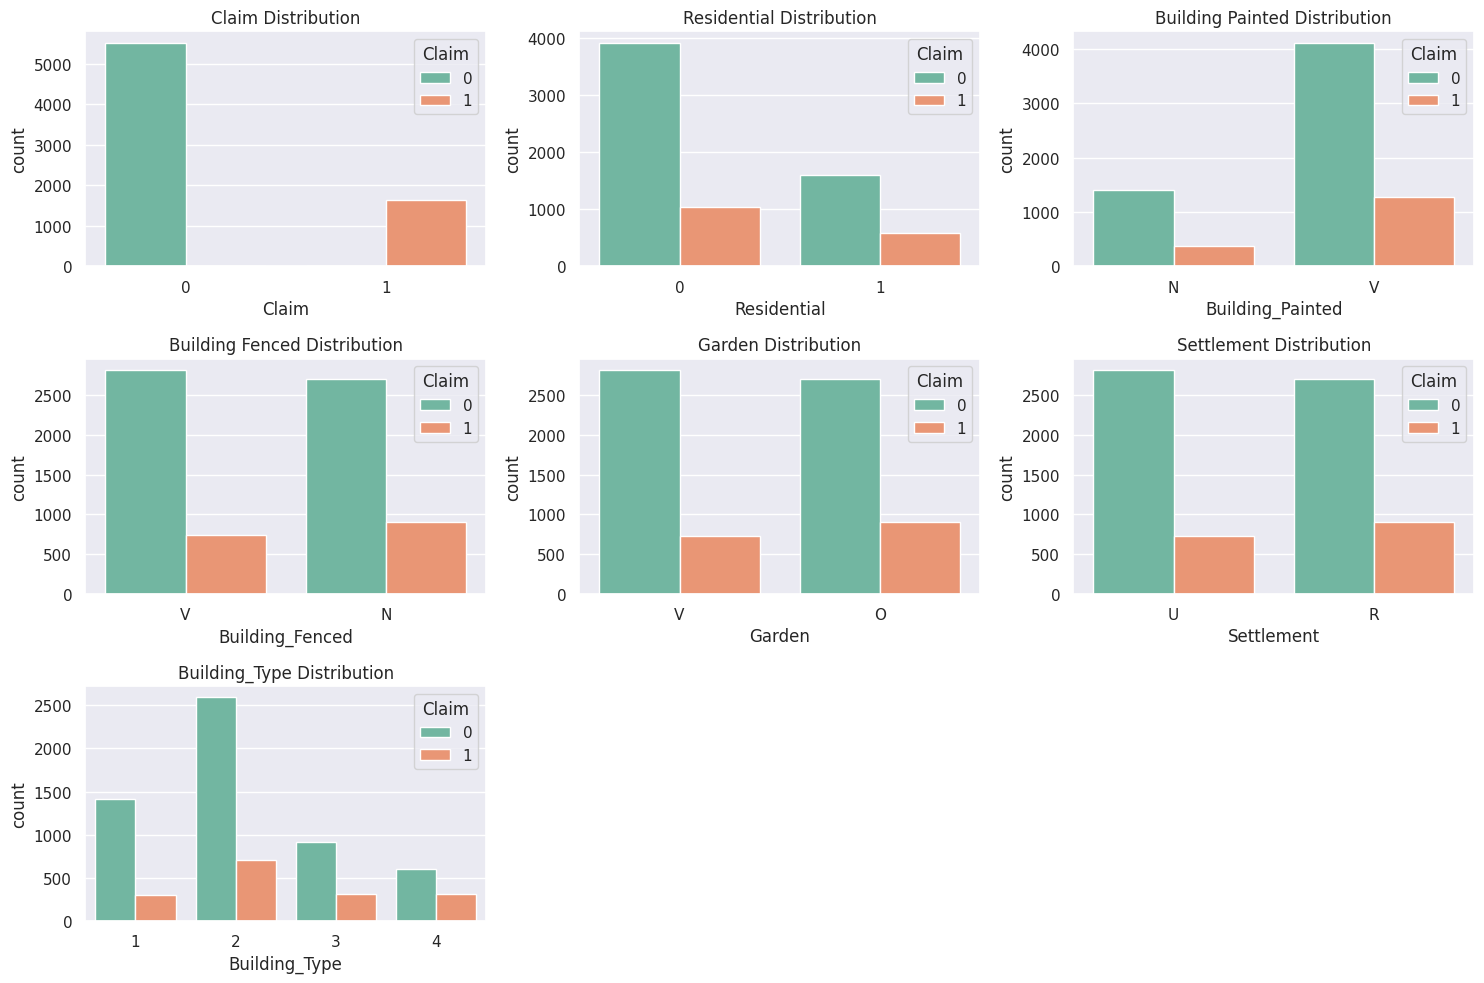

In [253]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
sns.set_theme(style="darkgrid")
# Plot the Claim distribution
sns.countplot(data=df, x='Claim', ax=axes[0, 0], hue = 'Claim', palette='Set2')
axes[0, 0].set_title('Claim Distribution')

# Plot the Residential distribution
sns.countplot(data=df, x='Residential', ax=axes[0, 1], hue = 'Claim',palette='Set2')
axes[0, 1].set_title('Residential Distribution')


# Plot the Building Painted distribution
sns.countplot(data=df, x='Building_Painted', ax=axes[0, 2], hue = 'Claim',palette='Set2')
axes[0, 2].set_title('Building Painted Distribution')

# Plot the Building Fenced distribution
sns.countplot(data=df, x='Building_Fenced', ax=axes[1, 0], hue = 'Claim',palette='Set2')
axes[1, 0].set_title('Building Fenced Distribution')

#Plot the Garden distribution
sns.countplot(data=df, x='Garden', ax=axes[1, 1], hue = 'Claim',palette='Set2')
axes[1, 1].set_title('Garden Distribution')

# Plot the Settlement distribution
sns.countplot(data=df, x='Settlement', ax=axes[1, 2], hue = 'Claim',palette='Set2')
axes[1, 2].set_title('Settlement Distribution')

#Plot the Building_Type distribution
sns.countplot(data=df, x='Building_Type', ax=axes[2, 0], hue = 'Claim',palette='Set2')
axes[2, 0].set_title('Building_Type Distribution')


#Plot the Insured_Period distribution
#sns.countplot(data=df, x='Insured_Period', ax=axes[2, 1],palette='Set3')
#axes[2, 1].set_title('Insured_Period Distribution')


fig.delaxes(axes[2, 1])
fig.delaxes(axes[2, 2])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


From here, we can observe that;

1. Non residential houses have a high rate of no claim
2. Not painted building have high rates of no claim
3. Theres low claim among buildings that arent fenced
4. Theres high claim among houses with no gardens
5. The no claim rates among houses in urban and rural areas are similar
6. Buildings of type 2 have high rates of no claim


In [254]:
#Creating a list for numerical columns
numerical_cont

['Building Dimension', 'Date_of_Occupancy']

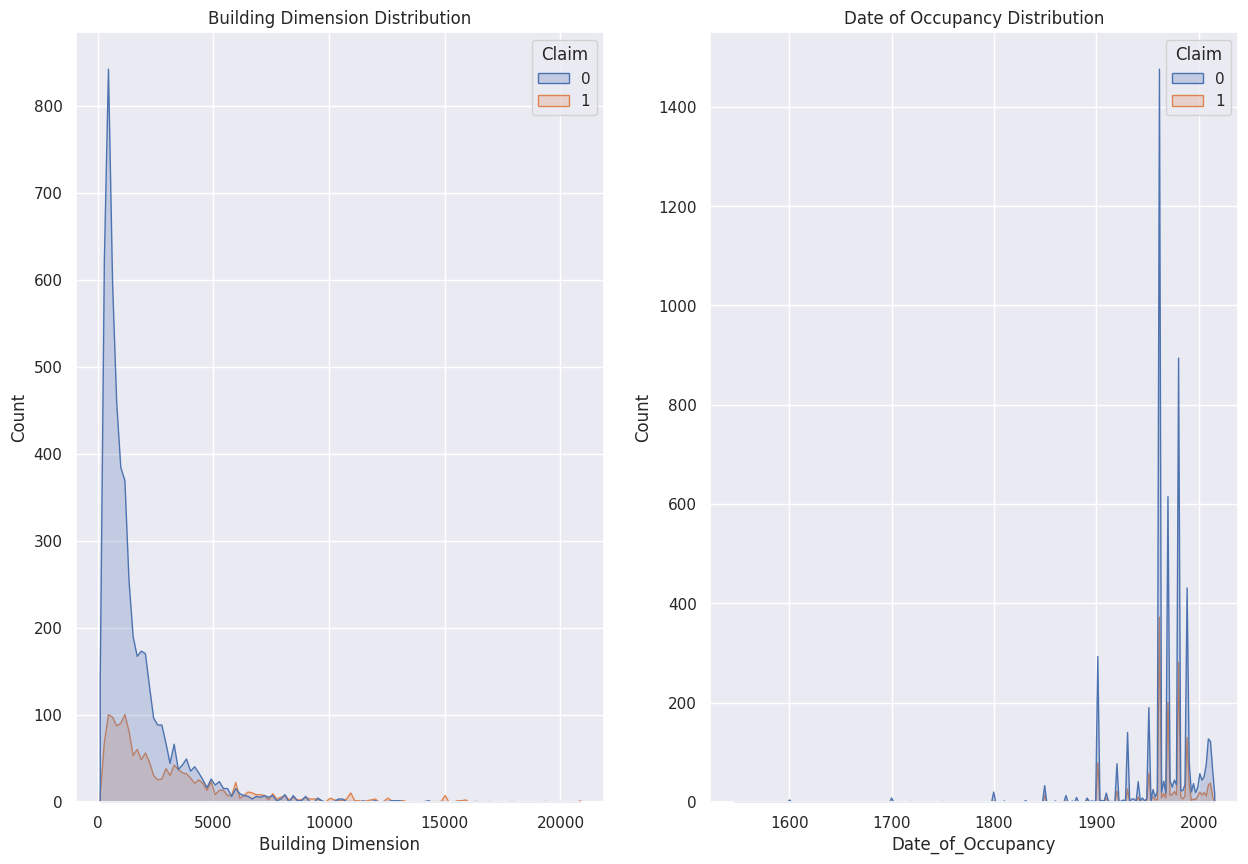

In [255]:
#Distribution of continous variables vs claim
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
sns.set_theme(style="darkgrid")
sns.histplot(df, x="Building Dimension", hue="Claim", element="poly", ax=axes[0])

axes[0].set_title("Building Dimension Distribution")

sns.histplot(df, x="Date_of_Occupancy", hue="Claim", element="poly", ax=axes[1])
axes[1].set_title("Date of Occupancy Distribution")

plt.show()

From here, we notice that,
1. There high rates of no claim for houses with dimensions from 0-5000
2. There high rates of no claim for houses with date_of_occupacy between 1900_2000

In [256]:
#Data Encoding
df['Building_Painted'] = df['Building_Painted'].replace({'V':0, 'N':1})

df['Building_Fenced']= df['Building_Fenced'].replace({'V':0, 'N':1})

df['Garden']= df['Garden'].replace({'O':0, 'V':1})

df['Settlement']= df['Settlement'].replace({'R':0, 'U':1})

df['Building_Type']= df['Building_Type'].replace({'1':0, '2':1, '3':2, '4':3})

In [257]:
# Removing outliers for 'Building Dimensions'
low, high = df['Building Dimension'].quantile([0.1, 0.9])
mask_date = df['Building Dimension'].between(low, high)
df = df[mask_date]

In [258]:
#Removing outliers for 'Date_of_Occupacy'
low, high = df['Date_of_Occupancy'].quantile([0.1,0.9])
mask_date = df['Date_of_Occupancy'].between(low, high)
df= df[mask_date]

In [259]:
#Checking for the new description
df.describe()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,Claim
count,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000,4686.000000
mean,2013.666453,0.911699,0.293641,0.305805,0.393086,0.606701,0.606487,1389.158344,2.199744,1967.946223,0.209347
std,1.384444,0.240086,0.455478,0.460797,0.488488,0.488534,0.488581,982.316709,0.938338,15.541266,0.406886
min,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,330.000000,1.000000,1920.000000,0.000000
25%,2012.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,600.000000,2.000000,1960.000000,0.000000
50%,2013.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1083.000000,2.000000,1970.000000,0.000000
75%,2015.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1900.000000,3.000000,1980.000000,0.000000
max,2016.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4300.000000,4.000000,1999.000000,1.000000


**Feature Selection**

In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4686 entries, 2 to 7158
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   4686 non-null   int64  
 1   Insured_Period      4686 non-null   float64
 2   Residential         4686 non-null   int64  
 3   Building_Painted    4686 non-null   int64  
 4   Building_Fenced     4686 non-null   int64  
 5   Garden              4686 non-null   int64  
 6   Settlement          4686 non-null   int64  
 7   Building Dimension  4686 non-null   float64
 8   Building_Type       4686 non-null   int64  
 9   Date_of_Occupancy   4686 non-null   float64
 10  Claim               4686 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 439.3 KB


In [261]:
df.shape

(4686, 11)

In [262]:
#Getting the target feature(attribution) and storing it in a, and the rest of the features in b
a = df.drop(columns=['Claim'])  # Features
b = df['Claim']  # Target variable

In [263]:
#Feature selection using chi-squared statistics and ANOVA F-statistic
from sklearn.feature_selection import SelectKBest, chi2, f_classif

# Calculate chi-squared statistics for each feature
chi2_scores = chi2(a, b)[0]

# Calculate ANOVA F-statistic and p-values for each feature
f_scores = f_classif(a, b)[0]

# Combine chi-squared and ANOVA scores
combined_scores = chi2_scores + f_scores

feature_scores = pd.DataFrame({'Feature': a.columns, 'Combined_Score': combined_scores})
feature_scores = feature_scores.sort_values(by='Combined_Score', ascending=False)
#feature_scores

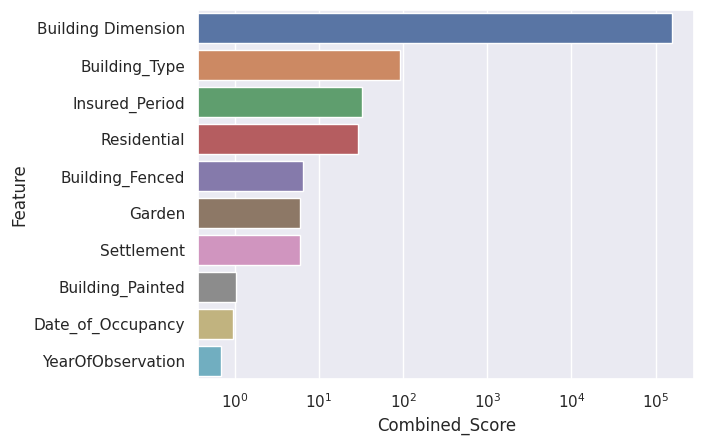

In [264]:
#Feature selection
sns.barplot(feature_scores, y ='Feature', x ='Combined_Score')
plt.xscale('log')

**Importing test Data**

In [265]:
#Importing the test data
df_test = pd.read_csv('/content/drive/MyDrive/Datasets/Insurance/test_data.csv')
df_test.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0,3,3310
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0,3,3310
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0,.,3310
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0,3,3321


In [266]:
df_test.shape

(3069, 13)

In [267]:
#Checking for null values
df_test.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  4
Settlement              0
Building Dimension     13
Building_Type           0
Date_of_Occupancy     728
NumberOfWindows         0
Geo_Code               13
dtype: int64

In [268]:
#Replacing missing values in Geo_code with mode
df_test['Geo_Code'] = df_test['Geo_Code'].fillna(df_test['Geo_Code'].mode()[0])

In [269]:
#Replacing missing values in Garden with mode
df_test['Garden']= df_test['Garden'].fillna(df_test['Garden'].mode()[0])

In [270]:
#Distribution of data is skewed hence we use median
df_test['Building Dimension'] = df_test['Building Dimension'].fillna(df_test['Building Dimension'].median())

In [271]:
#Dropping the numberofwindows and Geocode columns
df_test.drop(columns=['NumberOfWindows', 'Geo_Code'],inplace=True)

In [272]:
#Replacing missing values in Date of occupacy with median
df_test['Date_of_Occupancy'] = df_test['Date_of_Occupancy'].fillna(df_test['Date_of_Occupancy'].median())

In [273]:
df_test.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0


In [274]:
df_test_new = df_test.copy()
df_test_new.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy
0,H11920,2013,1.000000,0,V,N,O,R,300.0,1,1960.0
1,H11921,2016,0.997268,0,V,N,O,R,300.0,1,1960.0
2,H9805,2013,0.369863,0,V,V,V,U,790.0,1,1960.0
3,H7493,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0
4,H7494,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0


In [275]:
df_test.drop(columns=['Customer Id'], inplace = True)

In [276]:
df_test.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy
0,2013,1.000000,0,V,N,O,R,300.0,1,1960.0
1,2016,0.997268,0,V,N,O,R,300.0,1,1960.0
2,2013,0.369863,0,V,V,V,U,790.0,1,1960.0
3,2014,1.000000,0,V,N,O,R,1405.0,1,2004.0
4,2016,1.000000,0,V,N,O,R,1405.0,1,2004.0


In [277]:
#Encoding data in the xtest
df_test['Building_Painted'] = df_test['Building_Painted'].replace({'V':0, 'N':1})

df_test['Building_Fenced']= df_test['Building_Fenced'].replace({'V':0, 'N':1})

df_test['Garden']= df_test['Garden'].replace({'O':0, 'V':1})

df_test['Settlement']= df_test['Settlement'].replace({'R':0, 'U':1})

df_test['Building_Type']= df_test['Building_Type'].replace({'1':0, '2':1, '3':2, '4':3})

In [278]:
#Displaying first 5 rows
df_test.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy
0,2013,1.000000,0,0,1,0,0,300.0,1,1960.0
1,2016,0.997268,0,0,1,0,0,300.0,1,1960.0
2,2013,0.369863,0,0,0,1,1,790.0,1,1960.0
3,2014,1.000000,0,0,1,0,0,1405.0,1,2004.0
4,2016,1.000000,0,0,1,0,0,1405.0,1,2004.0


In [279]:
#checking for datatypes in
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069 entries, 0 to 3068
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YearOfObservation   3069 non-null   int64  
 1   Insured_Period      3069 non-null   float64
 2   Residential         3069 non-null   int64  
 3   Building_Painted    3069 non-null   int64  
 4   Building_Fenced     3069 non-null   int64  
 5   Garden              3069 non-null   int64  
 6   Settlement          3069 non-null   int64  
 7   Building Dimension  3069 non-null   float64
 8   Building_Type       3069 non-null   int64  
 9   Date_of_Occupancy   3069 non-null   float64
dtypes: float64(3), int64(7)
memory usage: 239.9 KB


In [280]:
df_test.shape

(3069, 10)

In [281]:
X_test = df_test.copy()

**Model Building**

In [282]:
x = df.drop(columns=['Claim'])  # Features
y = df['Claim']  # Target variable

In [283]:
x

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy
2,2014,1.000000,0,1,0,1,1,595.0,1,1960.0
3,2013,1.000000,0,0,0,1,1,2840.0,1,1960.0
5,2012,1.000000,0,0,1,0,0,535.0,1,1980.0
6,2012,1.000000,0,1,0,1,1,2830.0,1,1988.0
10,2013,0.241096,0,0,1,0,0,550.0,1,1960.0
...,...,...,...,...,...,...,...,...,...,...
7151,2014,0.030137,0,0,0,1,1,1083.0,1,1970.0
7153,2013,1.000000,1,0,0,1,1,1083.0,2,1950.0
7156,2013,1.000000,0,0,0,1,1,1083.0,2,1980.0
7157,2016,0.038251,0,0,0,1,1,1083.0,1,1992.0


In [284]:
y

2       0
3       0
5       0
6       0
10      0
       ..
7151    0
7153    0
7156    1
7157    0
7158    0
Name: Claim, Length: 4686, dtype: int64

In [285]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size= 0.2, random_state =0)

In [286]:
y_train.value_counts()

0    2957
1     791
Name: Claim, dtype: int64

**Dealing with the imbalanced dataset using Smote**

In [287]:
#Before oversampling
#print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
#print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

In [288]:
# Apply SMOTE to oversample the minority class
#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X_resampled, y_resampled = smote.fit_resample(x_train, y_train)

# Print the class distribution after resampling
#print("Class distribution after resampling:", Counter(y_resampled))

In [289]:
#colors = ['#66b3ff', '#ff9999']
#explode = (0.05,0.05)
#plt.figure(figsize=(5, 5))
#plt.pie(pd.Series(y_resampled).value_counts(), colors = colors, labels=['No', 'Yes'],
 #       autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#plt.legend()
#plt.title("Oversampled Targets in Training Set")
#plt.show()

In [290]:
#splitting the resampled data into training and testing sets
#from sklearn.model_selection import train_test_split
#X1_train, X1_test, y1_train, y1_test = train_test_split(X_resampled, y_resampled, test_size= 0.20, random_state=0)

In [291]:
pd.set_option('display.max_columns',None)
X_train.head()


,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy
1399,2015,1.0,0,1,0,1,1,2025.0,2,1960.0
1602,2014,1.0,0,0,1,0,0,1330.0,2,1988.0
4152,2013,1.0,0,0,0,1,1,475.0,2,1970.0
4538,2015,1.0,1,0,0,1,1,1290.0,2,1970.0
6383,2015,1.0,0,0,0,1,1,2062.0,3,1960.0


In [292]:
X_train.shape

(3748, 10)

In [293]:
X_train['Building Dimension']

1399    2025.0
1602    1330.0
4152     475.0
4538    1290.0
6383    2062.0
         ...  
1562     530.0
4960    1140.0
2528    3600.0
3959    4300.0
4133     360.0
Name: Building Dimension, Length: 3748, dtype: float64

In [294]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns_to_standardize = ['YearOfObservation','Building Dimension', 'Date_of_Occupancy']
X_train[columns_to_standardize] = scaler.fit_transform(X_train[columns_to_standardize])
X_val[columns_to_standardize] = scaler.transform(X_val[columns_to_standardize])

In [295]:
X_train.head()

,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy
1399,0.957814,1.0,0,1,0,1,1,0.654169,2,-0.504795
1602,0.236519,1.0,0,0,1,0,0,-0.054808,2,1.299108
4152,-0.484776,1.0,0,0,0,1,1,-0.927003,2,0.139456
4538,0.957814,1.0,1,0,0,1,1,-0.095613,2,0.139456
6383,0.957814,1.0,0,0,0,1,1,0.691913,3,-0.504795


**Building SVM**

In [296]:
from sklearn.svm import SVC
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_val)
#acc_svc = (svm_classifier.score(X_train, y_train))
#acc_svc

In [297]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
cm1 = confusion_matrix(y_val, y_pred_svm)
print(cm1)
acc_svc = accuracy_score(y_val, y_pred_svm)
acc_svc
print(classification_report(y_val, y_pred_svm))

[[745   3]
 [188   2]]
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       748
           1       0.40      0.01      0.02       190

    accuracy                           0.80       938
   macro avg       0.60      0.50      0.45       938
weighted avg       0.72      0.80      0.71       938



In [298]:
metrics.roc_auc_score(y_val, y_pred_svm)

0.5032578103011539

In [299]:
#Hyperparamter tuning using Gridsearch

#svm_params = {"C":(0.1, 0.5, 1, 2, 5, 10, 20),
 #         "gamma":(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1),
  #        "kernel":('linear', 'poly', 'rbf')}

#grid_search = GridSearchCV(estimator= svm_classifier, param_grid=svm_params, scoring = 'accuracy', cv =10)

#grid_search.fit(X_train, y_train)
#best_accuracy = grid_search.best_score_
#best_parameters = grid_search.best_params_

#print('Best Accuracy: {:.2f}%' .format(best_accuracy*100))
#print('Best Parameters:', best_parameters)


In [300]:
#other option for tuning
# Tunning Params
#parameters = [
#              {'C': [1, 10, 100, 1000],
#               'kernel': ['linear']
#              },
#              {'C': [1, 10, 100, 1000],
#               'gamma': [0.001, 0.0001],
#               'kernel': ['rbf']
#              }
#]
#grid_search = GridSearchCV(estimator= svm_classifier, param_grid=parameters, scoring = 'accuracy', cv =10)

#grid_search.fit(X_train, y_train)
#best_accuracy = grid_search.best_score_
#best_parameters = grid_search.best_params_

#print('Best Accuracy: {:.2f}%' .format(best_accuracy*100))
#print('Best Parameters:', best_parameters)


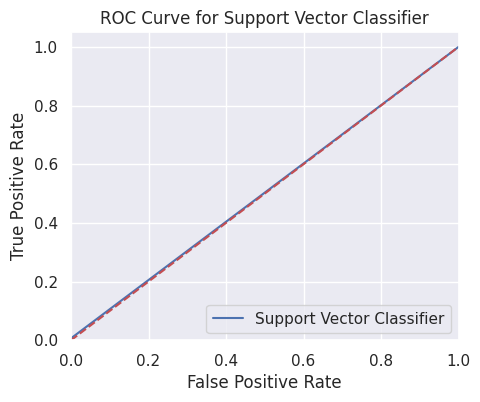

In [301]:
# Visualisation of the models's performance on an ROC/AUC curve
plt.figure(figsize=(5,4))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_svm)
nb_roc_auc2=roc_auc_score(y_val,svm_classifier.predict(X_val))
plt.plot(fpr, tpr, label='Support Vector Classifier')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='lower right')
plt.title('ROC Curve for Support Vector Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**Linear Regression Model**

In [302]:
from sklearn.linear_model import LinearRegression
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
y_pred_lin = linear_reg_model.predict(X_val)

In [303]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_val, y_pred_lin)
rmse = mean_squared_error(y_val, y_pred_lin, squared=False)
r2= r2_score(y_val, y_pred_lin)

print(f'MSE:{mse}')
print(f'RMSE:{rmse}')
print(f'R2:{r2}')

MSE:1.1968419136160797e+23
RMSE:345954030705.82654
R2:-7.409472112606432e+23


In [304]:
linear_reg_model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

In [305]:
# Define the parameter grid
linear_params = {
    'fit_intercept': [True, False],
    'positive': [True, False]
}

grid_search = GridSearchCV(estimator= linear_reg_model, param_grid= linear_params, scoring = 'neg_mean_squared_error', cv =10, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model_lin = grid_search.best_estimator_


# Make predictions on the test set
y_pred = best_model_lin.predict(X_val)



In [306]:
mse2 = mean_squared_error(y_val, y_pred)
rmse2 = np.sqrt(mse2)
r22 = r2_score(y_val, y_pred)

print(f'Mean Squared Error (MSE): {mse2}')
print(f'Root Mean Squared Error (RMSE): {rmse2}')
print(f'R-squared (R2): {r22}')



Mean Squared Error (MSE): 0.15384419480998193
Root Mean Squared Error (RMSE): 0.39222977297750095
R-squared (R2): 0.047573235727598084


In [307]:
metrics.roc_auc_score(y_val, y_pred_lin)

0.6515444694624261

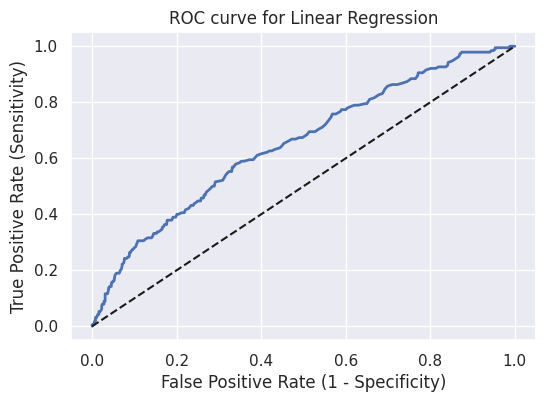

In [308]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_lin)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12

plt.title('ROC curve for Linear Regression')

plt.xlabel('False Positive Rate (1 - Specificity)')

plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

**K-Nearest Neighbours**

In [309]:
from sklearn.neighbors import KNeighborsClassifier
KNN_classifier = KNeighborsClassifier(n_neighbors = 5)
KNN_classifier.fit(X_train, y_train)
#acc_knn = (KNN_classifier.score(X_train, y_train))
#acc_knn

KNeighborsClassifier()

In [310]:
y_pred_knn = KNN_classifier.predict(X_val)

In [311]:
cm3 = confusion_matrix(y_val, y_pred_knn)
print(cm3)
accuracy_score(y_val, y_pred_knn)

[[674  74]
 [169  21]]


0.7409381663113006

In [312]:
metrics.roc_auc_score(y_val, y_pred_knn)

0.5057979172530256

In [211]:
# Tunning Params
knn_params = {
    'n_neighbors': list(range(1, 30)),
    'leaf_size': list(range(1,30)),
    'weights': [ 'distance', 'uniform' ]
}
grid_search = GridSearchCV(estimator= KNN_classifier, param_grid=knn_params, scoring = 'accuracy', cv =10)
grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('Best Accuracy: {:.2f}%' .format(best_accuracy*100))
print('Best Parameters:', best_parameters)


Best Accuracy: 79.03%
Best Parameters: {'leaf_size': 1, 'n_neighbors': 26, 'weights': 'uniform'}


In [313]:
KNN_classifier2 = KNeighborsClassifier(leaf_size= 1, n_neighbors= 26, weights= 'uniform')
KNN_classifier2.fit(X_train, y_train)


KNeighborsClassifier(leaf_size=1, n_neighbors=26)

In [314]:
y_pred_knn2 =KNN_classifier2.predict(X_val)
cm33 = confusion_matrix(y_val, y_pred_knn2)
print(cm33)
knn2 = accuracy_score(y_val, y_pred_knn2)
print(f'Accuracy: {knn2}')

[[731  17]
 [182   8]]
Accuracy: 0.7878464818763327


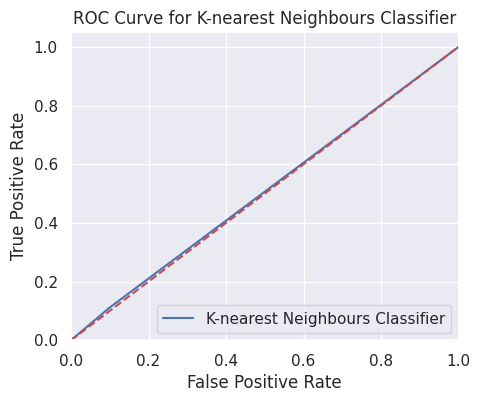

In [315]:
plt.figure(figsize=(5,4))
fpr, tpr, thresholds = roc_curve(y_val, y_pred_knn)
nb_roc_auc2=roc_auc_score(y_val, KNN_classifier.predict(X_val))
plt.plot(fpr, tpr, label='K-nearest Neighbours Classifier')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='lower right')
plt.title('ROC Curve for K-nearest Neighbours Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

**Naive Bayes**

In [316]:
from sklearn.naive_bayes import GaussianNB
NaiveBayes_classifier = GaussianNB()
NaiveBayes_classifier.fit(X_train, y_train)
y_pred_nb = NaiveBayes_classifier.predict(X_val)
#acc_gaussian =(NaiveBayes_classifier.score(X_train, y_train))
#acc_gaussian

In [317]:
metrics.roc_auc_score(y_val, y_pred_nb)

0.5631930762735716

In [318]:
cm4 = confusion_matrix(y_val, y_pred_nb)
print(cm4)
accuracy_score(y_val, y_pred_nb)

[[689  59]
 [151  39]]


0.7761194029850746

In [194]:
# Tunning Params
NB_params = {'var_smoothing': [1e-11, 1e-10, 1e-9]}

grid_search = GridSearchCV(estimator= NaiveBayes_classifier, param_grid=NB_params, scoring = 'accuracy', cv =10)

grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('Best Accuracy: {:.2f}%' .format(best_accuracy*100))
print('Best Parameters:', best_parameters)


Best Accuracy: 77.24%
Best Parameters: {'var_smoothing': 1e-11}


In [319]:
NaiveBayes_classifier2 = GaussianNB(var_smoothing= 1e-11)
NaiveBayes_classifier2.fit(X_train, y_train)
y_pred_nb2 = NaiveBayes_classifier2.predict(X_val)

In [320]:
cm44 = confusion_matrix(y_val, y_pred_nb2)
print(cm44)
nb2 = accuracy_score(y_val, y_pred_nb2)
print(f'Accuracy: {nb2}')

[[689  59]
 [151  39]]
Accuracy: 0.7761194029850746


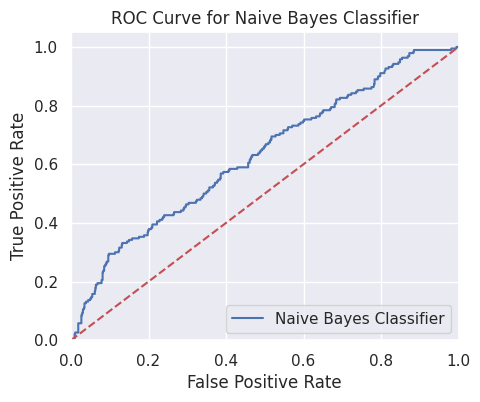

In [321]:
# Visualisation of the models's performance on an ROC/AUC curve
plt.figure(figsize=(5,4))
y_predictnb_proba = NaiveBayes_classifier.predict_proba(X_val)[:,1]
fpr, tpr, thresholds = roc_curve(y_val,  y_predictnb_proba)
nb_roc_auc2=roc_auc_score(y_val,NaiveBayes_classifier.predict(X_val))
plt.plot(fpr, tpr, label='Naive Bayes Classifier')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.legend(loc='lower right')
plt.title('ROC Curve for Naive Bayes Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()


In [322]:
#Creating a dataframe showing the models and respective accuracy scores
models = pd.DataFrame({
    'Model': ['Support Vector Machines','Linear Regression', 'KNN','Naive Bayes'],
   'Score': [acc_svc,  rmse2, knn2, nb2]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Support Vector Machines,0.796375
2,KNN,0.787846
3,Naive Bayes,0.776119
1,Linear Regression,0.392230


In [323]:
X_train.shape

(3748, 10)

In [324]:
X_test.shape

(3069, 10)

In [325]:
#Convert the test data into an array
test_array = np.array(df_test)

**SVM prediction**

In [326]:
#Predicted Claim Status
predicted_values = svm_classifier.predict(test_array)

#Convert the predicted values to an dataframe
predicted_df = pd.DataFrame(predicted_values, columns=['Claim'])

#Creat a dataframe for the customer id
col = ['Customer Id']
customer_id_df = df_test_new[col]

predicted_df_final= pd.concat([customer_id_df,predicted_df], axis=1)

predicted_df_final.to_csv('Predictions_Output1.csv', index =False)

**Linear Regression**

In [327]:
#Predicted Claim Status
predicted_values = best_model_lin.predict(test_array)

#Convert the predicted values to an dataframe
predicted_df = pd.DataFrame(predicted_values, columns=['Claim'])

#Creat a dataframe for the customer id
col = ['Customer Id']
customer_id_df = df_test_new[col]

predicted_df_final= pd.concat([customer_id_df,predicted_df], axis=1)

predicted_df_final.to_csv('Predictions_Output3.csv', index =False)

**KNN prediction**

In [328]:
#Predicted Claim Status
predicted_values = KNN_classifier2.predict(test_array)

#Convert the predicted values to an dataframe
predicted_df = pd.DataFrame(predicted_values, columns=['Claim'])

#Creat a dataframe for the customer id
col = ['Customer Id']
customer_id_df = df_test_new[col]

predicted_df_final= pd.concat([customer_id_df,predicted_df], axis=1)

predicted_df_final.to_csv('Predictions_Output2.csv', index =False)

**Naive Bayes**

In [329]:
#Predicted Claim Status
predicted_values = NaiveBayes_classifier2.predict(test_array)

#Convert the predicted values to an dataframe
predicted_df = pd.DataFrame(predicted_values, columns=['Claim'])

#Creat a dataframe for the customer id
col = ['Customer Id']
customer_id_df = df_test_new[col]

predicted_df_final= pd.concat([customer_id_df,predicted_df], axis=1)

predicted_df_final.to_csv('Predictions_Output4.csv', index =False)